# Node identifier: Autoencoder, reconstruction error approach

## Preparation

### Load data

In [101]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
import sys
from sklearn.metrics import *
import torch.utils.data as data 
import torch
from torch.nn import Linear
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm# Load train and test set
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F

In [102]:
# Load train and test set
path = 'C:/Users/User/Desktop/Assignatures/Synthesis project/GraphAnomaly/dades_arnau/'

In [103]:
# Use sequential split
with open(path + 'sequential_train.pkl', 'rb') as f:
    train_seq = pickle.load(f)
with open(path + 'sequential_validation.pkl', 'rb') as f:
    test_seq = pickle.load(f)

In [104]:
# Separate labels
def separate_labels(train_set, test_set):
    # Split train data in licit and ilicit
    X_ilicit = train_set.loc[train_set['class'].isin([0])] 
    X_licit = train_set.loc[train_set['class'].isin([1])] 
    X_ilicit = X_ilicit.drop(columns=['class'])
    X_licit = X_licit.drop(columns=['class'])

    y_ilicit = list(train_set.loc[train_set['class'].isin([0])]['class'])
    y_licit = list(train_set.loc[train_set['class'].isin([1])]['class'])
    

    test_set = test_set.loc[test_set['class'].isin([0, 1])] # Drop unknown
    y_test = list(test_set['class'])
    X_test = test_set.drop(columns=['class'])

    return X_ilicit, y_ilicit, X_licit, y_licit, X_test, y_test

In [105]:
X_ilicit, y_ilicit, X_licit, y_licit, test_ilicit_X, test_ilicit_y, test_licit_X, test_licit_y = separate_labels(train_seq, test_seq)

ValueError: not enough values to unpack (expected 8, got 6)

### Preparate data for the model

In [108]:
class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = X        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):        
        return self.X[idx]

In [109]:
licit_train = CustomDataset(torch.tensor(X_licit.values, dtype=torch.float32))
ilicit_train = CustomDataset(torch.tensor(X_ilicit.values, dtype=torch.float32))
licit_test = CustomDataset(torch.tensor(test_licit_X.values, dtype=torch.float32))
ilicit_test = CustomDataset(torch.tensor(test_ilicit_X.values, dtype=torch.float32)) 

train_loader = DataLoader(licit_train, batch_size=128, shuffle=True)
val_loader = DataLoader(licit_test, batch_size=128, shuffle=False)
ilicit_train_loader = DataLoader(ilicit_train, batch_size=128, shuffle=False)
ilicit_test_loader = DataLoader(ilicit_test, batch_size=128, shuffle=False)

## Autoencoder

In [80]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=50):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, 100),
            nn.Tanh(),
            nn.Linear(100, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [94]:
def train_ae(autoencoder, train_loader, val_loader, criterion, optimizer, num_epochs=10): 
    total_train_loss = [] 
    total_validation_loss = []

    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        for inputs in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = autoencoder(inputs)
            
            # Compute the loss
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        total_train_loss.append(train_loss)
        
        #validació dins del mateix train loop
        validation_loss = val_ae(autoencoder=autoencoder, data_loader=val_loader, criterion=criterion)
        print(f"Validation Loss: {validation_loss:.4f}")
        total_validation_loss.append(validation_loss)
    return total_train_loss, total_validation_loss

def val_ae(autoencoder, data_loader, criterion):
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in data_loader:
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss = loss / 1_000
            val_loss += loss.item()
    epoch_loss = val_loss / len(data_loader.dataset)
    return epoch_loss


In [95]:
#hiperparàmetres
lr = 0.001
EPOCHS = 80

input_dim = X_licit.shape[1]
model = Autoencoder(input_dim=input_dim,encoding_dim=50)
criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

training_loss, validation_loss = train_ae(autoencoder=model, train_loader=train_loader, criterion=criterion, 
                                          optimizer=optimizer, val_loader=val_loader, num_epochs=EPOCHS)
torch.save(model.state_dict(), path + 'ae_rloss.pth')

Epoch [1/250], Training Loss: 1633.9031
Validation Loss: 10.6084
Epoch [2/250], Training Loss: 8.4371
Validation Loss: 3.9662
Epoch [3/250], Training Loss: 3.8290
Validation Loss: 2.1627
Epoch [4/250], Training Loss: 2.2635
Validation Loss: 1.3852
Epoch [5/250], Training Loss: 1.5152
Validation Loss: 0.9715
Epoch [6/250], Training Loss: 1.0926
Validation Loss: 0.7202
Epoch [7/250], Training Loss: 0.8268
Validation Loss: 0.5588
Epoch [8/250], Training Loss: 0.6477
Validation Loss: 0.4443
Epoch [9/250], Training Loss: 0.5207
Validation Loss: 0.3632
Epoch [10/250], Training Loss: 0.4269
Validation Loss: 0.3004
Epoch [11/250], Training Loss: 0.3557
Validation Loss: 0.2528
Epoch [12/250], Training Loss: 0.3004
Validation Loss: 0.2163
Epoch [13/250], Training Loss: 0.2558
Validation Loss: 0.1840
Epoch [14/250], Training Loss: 0.2202
Validation Loss: 0.1597
Epoch [15/250], Training Loss: 0.1912
Validation Loss: 0.1393
Epoch [16/250], Training Loss: 0.1662
Validation Loss: 0.1241
Epoch [17/250

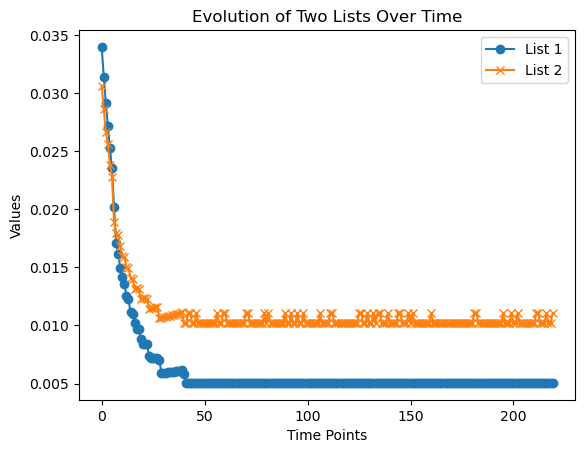

In [100]:
# Sample data: evolution of two lists over time
list1 = training_loss[30:]
list2 = validation_loss[30:]
time_points = range(len(list1))  # Assuming both lists have the same length

# Create a figure and axis
fig, ax = plt.subplots()

# Plot both lists
ax.plot(time_points, list1, label='List 1', marker='o')
ax.plot(time_points, list2, label='List 2', marker='x')

# Add titles and labels
ax.set_title('Evolution of Two Lists Over Time')
ax.set_xlabel('Time Points')
ax.set_ylabel('Values')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [140]:
def infer_AE(loader, model):    
    loss_history = []

    # Iterate through the dataset
    with torch.no_grad():
        for inputs in loader:           
            outputs = model(inputs)            
            loss = criterion(outputs, inputs)  # Compute reconstruction loss
            loss = loss / 1_000
            loss_history.append(float(loss))               

    return loss_history

In [141]:
# Define the path to the saved model
model_path = path + 'ae_rloss.pt'
# Create an instance of your model
model = Autoencoder(input_dim)
# Load the state_dict into the model
model.load_state_dict(torch.load(model_path))

trainl_rloss = infer_AE(train_loader, model)
testl_rloss = infer_AE(val_loader, model)
trainil_rloss = infer_AE(ilicit_train_loader, model)
testil_rloss = infer_AE(ilicit_test_loader, model)

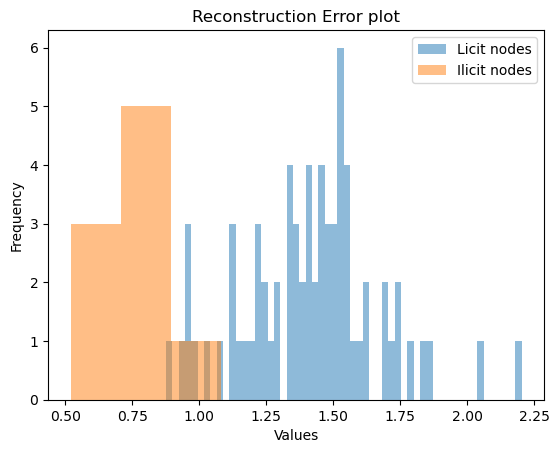

In [143]:
# Determine the range of values in both lists
min_value = min(min(testl_rloss), min(testil_rloss))
max_value = max(max(testl_rloss), max(testil_rloss))

# Plot histograms for both lists with 10 bins
plt.hist(testl_rloss, bins=len(testl_rloss), alpha=0.5, label='Licit nodes', range=(min_value, max_value))
plt.hist(testil_rloss, bins=len(testil_rloss), alpha=0.5, label='Ilicit nodes', range=(min_value, max_value))

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Reconstruction Error plot')

# Add legend
plt.legend()

# Show the plot
plt.show()